# A Trip Down Raytracing with Data-Parallel C++
This notebook takes as inspiration the conceptual simplicity of ray-tracing computations and coupling it to notion that it scales in the task-parallel and data-parallel computations.

Inspiration for the overall flow and layout of the notebook is inspired to the "literate programming" style adopted by PBRT.  The compactness and small size of the main code is attributed to the wonderful work by K. Beason and D. Sokolov, respectively.

***
# Goal of the Module:  Build a "tiny raytracer" and use Data-Parallel C++ To Enhance Performance
The goal of the training session is to take a step-by-step approach towards building a "tiny raytracer."  Not quite as terse the 99-lines or 256-lines approach espoused by Beason and Sokolov, resptively.  However, the desire to produce a readable source code base and use that as the scaffolding to apply Data-Parallel C++ where it makes sense.

The code will be written such that it clearly shows the expressibility and ease of adding DPC++ to the code and getting attendant performance in turn.

## Quick tour of DPC++
The programming language for oneAPI is Data Parallel C++ (DPC++) and employs modern features of the C++ language to enact its parallelism. In fact, the oneAPI programmerProgrammers using oneAPI will routinely uses language features such as C++ lambdas, templates, parallel_for, and closures.

If you are unfamiliar with these modern C++11 and later language features, consult other C++ language references and gain a basic understanding before continuing.  Some online C++ language resources are as follows:
* C++ Reference - https://en.cppreference.com/w/
* Standard C++ Library reference - http://www.cplusplus.com/reference/

### oneAPI Software Model
The oneAPI Software Model used by oneAPI, including DPC++, is based upon the [SYCL* Specification](https://www.khronos.org/registry/SYCL/specs/sycl-1.2.1.pdf "SYCL 1.2.1 Specification"), and supports SYCL completely. The specification presents a general heterogeneous compute capability by detailing four models. These models categorize the actions a developer needs to perform to employ one or more devices as an accelerator.  Aspects of these models appear in every oneAPI program. These models are summarized as:
* Platform model - Specifies the host and device(s).
* Execution model - Specifies the command queues and issuing commands for execution on the device(s).
* Memory model - Defines how the host and devices interact with memory. 
* Kernel model - Defines the code that executes on the device(s). This code is known as the kernel.

### Anatomy of a DPC++ Program
Put something in here about compostion of a DPC++ program

Walkthrough 
```cpp
#include <vector>
include <CL/sycl.hpp>

#define SIZE 1024

namespace sycl = cl::sycl;

int main() {
 std::array<int, SIZE> a, b, c;

  for (int i = 0; i<SIZE; ++i) {
    a[i] = i;
    b[i] = -i;
    c[i] = i;
  }

  {
  sycl::range<1> a_size{SIZE};

  auto platforms = sycl::platform::get_platforms();

  for (auto &platform : platforms) {

    std::cout << "Platform: "
      << platform.get_info<sycl::info::platform::name>()
      << std::endl;


    auto devices = platform.get_devices();
    for (auto &device : devices ) {
      std::cout << "  Device: "
        << device.get_info<sycl::info::device::name>()
        << std::endl;
    }

  }

  sycl::default_selector device_selector;
  sycl::queue d_queue(device_selector);

  sycl::buffer<int, 1>  a_device(a.data(), a_size);
  sycl::buffer<int, 1>  b_device(b.data(), a_size);
  sycl::buffer<int, 1>  c_device(c.data(), a_size);

  d_queue.submit([&](sycl::handler &cgh) {
    auto c_res = c_device.get_access<sycl::access::mode::write>(cgh);
    auto a_in = a_device.get_access<sycl::access::mode::read>(cgh);
    auto b_in = b_device.get_access<sycl::access::mode::read>(cgh);

    cgh.parallel_for<class ex1>(a_size,[=](sycl::id<1> idx) {
      c_res[idx] = a_in[idx] + b_in[idx];
    });

  });

  }
}
```

A oneAPI DPC++ program has the **single source** property, which means the host code and the device code can be placed in the same file so that the compiler treats them as the same compilation unit.

The three types of scope in oneAPI DPC++ programs include:
•	Application scope – Code that executes on the host
•	Command group scope – Code that acts as the interface between the host and device
•	Kernel scope – Code that executes on the device

### Plaform Model
The oneAPI platform model used by oneAPI, including DPC++, is based upon the SYCL* platform model, and includes SYCL completely

## Using DPC++ to Enhance Vector Math Operator
At this point we will dissect a vector math operator, rewrite it with DPC++ to enhance its throughput.

**Dot product**

```cpp
float dpcpp_dot(vec3 &v1, vec3 &v2)
{
        queue device_queue(cpu_selector(), async_exception_handler);

        buffer<vec3, 1> bufv1(&v1, range<1>(1));
        buffer<vec3, 1> bufv2(&v2, range<1>(1));

        float tmp{0.f};
        buffer<float, 1> bufv3(&tmp, range<1>(1));

        device_queue.submit([&](handler &cgh) {
            auto acc_v1 = bufv1.get_access<access::mode::read>(cgh);
            auto acc_v2 = bufv2.get_access<access::mode::read>(cgh);
            auto acc_v3 = bufv3.get_access<access::mode::write>(cgh);
            cgh.single_task<class dot_product>([=]() {
                acc_v3[0] = acc_v1[0]*acc_v2[0] + acc_v1[1]*acc_v2[1] + acc_v1[2]*acc_v2[2];
            });
        });
        device_queue.wait_and_throw();
        
        return std::move(tmp);
}
```



***
# Option 1:  The Making of the Raytracer in 9 Lessons
The next 9 steps in this lesson will walk you through a process of progressively adding functionality to previouslly completed steps.

The lessons are as follows:
1. Writing the framebuffer to disk
2. Perform raytracing on one object in the scene
3. Add more objects/spheres to the scene
4. Add lighting to the scene
5. Enable specular lighting
6. Enable shadown/self-shadowing in general
7. Add reflection to the properties
8. Add refraction to the properties
9. Add extra objects beyond spheres to the scene

***
## Lesson 1: write an image to the disk
First things first - let us write a simple image - an empty framebuffer to disk

In [1]:
%%writefile 'src/lesson1.cpp'

// Includes from the standard library
#include <limits> // the limits header
#include <cmath>
#include <iostream>
#include <fstream>
#include <vector>
#include <chrono>
#include <exception>

// Include for Google logging library Horray
#include <glog/logging.h>

// Include for SYCL - the front-end of DPC++
#include <CL/sycl.hpp>

// Includes for vector/matrix/geometric operations
#include "geometry.h"

using namespace std;

// ********************************************************************************
// The render function is at the heart of the work that the raytracer does
// ********************************************************************************

void render() {
    const int width    = 1024;
    const int height   = 768;
    std::vector<Vec3f> framebuffer(width*height);

    std::chrono::steady_clock::time_point begin = std::chrono::steady_clock::now();
    
    // cycle thru the height and width of the framebuffer, fill with stuff
    for (size_t j = 0; j<height; j++) {
        for (size_t i = 0; i<width; i++) {
            framebuffer[i+j*width] = Vec3f(j/float(height),i/float(width), 0);
        }
    }
    
    std::chrono::steady_clock::time_point end = std::chrono::steady_clock::now();
    std::cout << "Elapsed time:  " << std::chrono::duration_cast<std::chrono::milliseconds> (end - begin).count() << "[msecs]" << std::endl;

    std::ofstream ofs; // save the framebuffer to file
    ofs.open("imgs/lesson1.ppm");
    ofs << "P6\n" << width << " " << height << "\n255\n";
    for (size_t i = 0; i < height*width; ++i) {
        for (size_t j = 0; j<3; j++) {
            ofs << (char)(255 * std::max(0.f, std::min(1.f, framebuffer[i][j])));
        }
    }
    ofs.close();
}

// ********************************************************************************
// The main function is the entry-point for the program
// ********************************************************************************

int main(int argc, char** argv) try {
    
    // Initialize Google's logging library.
    google::InitGoogleLogging(argv[0]);
        
    render();
    return 0;
} catch( exception &e ) {
    std::cerr << "Exception thrown:  " << e.what() << std::endl;
    LOG(INFO) << "Exception thrown:  " << e.what();
    return 1;
}

Overwriting src/lesson1.cpp


In [2]:
! dpcpp src/lesson1.cpp -I./include -o ./bin/lesson1 -fopenmp -std=c++11 -lglog

In [3]:
! bin/lesson1

Elapsed time:  12[msecs]


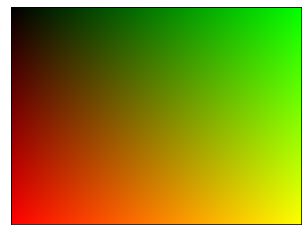

In [4]:
%matplotlib inline

import cv2
from matplotlib import pyplot as plt
import numpy as np

img = cv2.imread('imgs/lesson1.ppm')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

***
## Step 2, the crucial one: ray trace one object

Introduce the various simple concepts of what is raytracing

In [5]:
%%writefile src/main2.cpp

#include <limits>
#include <cmath>
#include <iostream>
#include <fstream>
#include <vector>

#include <CL/sycl.hpp>

#include "geometry.h"

    
struct Sphere {
    Vec3f center;
    float radius;

    Sphere(const Vec3f &c, const float &r) : center(c), radius(r) {}

    bool ray_intersect(const Vec3f &orig, const Vec3f &dir, float &t0) const {
        Vec3f L = center - orig;
        float tca = L*dir;
        float d2 = L*L - tca*tca;
        if (d2 > radius*radius) return false;
        float thc = sqrtf(radius*radius - d2);
        t0       = tca - thc;
        float t1 = tca + thc;
        if (t0 < 0) t0 = t1;
        if (t0 < 0) return false;
        return true;
        }
     };

    Vec3f cast_ray(const Vec3f &orig, const Vec3f &dir, const Sphere &sphere) {
        float sphere_dist = std::numeric_limits<float>::max();
        if (!sphere.ray_intersect(orig, dir, sphere_dist)) {
            return Vec3f(0.2, 0.7, 0.8); // background color
        }

        return Vec3f(0.4, 0.4, 0.3);
    }

void render(const Sphere &sphere) {

    const int width    = 1024;
    const int height   = 768;
    const int fov      = M_PI/2.;

    std::vector<Vec3f> framebuffer(width*height);

    #pragma omp parallel for
    for (size_t j = 0; j<height; j++) {
        for (size_t i = 0; i<width; i++) {
            float x =  (2*(i + 0.5)/(float)width  - 1)*tan(fov/2.)*width/(float)height;
            float y = -(2*(j + 0.5)/(float)height - 1)*tan(fov/2.);
            Vec3f dir = Vec3f(x, y, -1).normalize();
            framebuffer[i+j*width] = cast_ray(Vec3f(0,0,0), dir, sphere);
        }
    }

    std::ofstream ofs; // save the framebuffer to file
    ofs.open("imgs/out2.ppm");
    ofs << "P6\n" << width << " " << height << "\n255\n";
    for (size_t i = 0; i < height*width; ++i) {
        for (size_t j = 0; j<3; j++) {
            ofs << (char)(255 * std::max(0.f, std::min(1.f, framebuffer[i][j])));
        }
    }
    ofs.close();
}

int main() {
    Sphere sphere(Vec3f(-3, 0, -16), 2);
    render(sphere);
    return 0;
}

Overwriting src/main2.cpp


In [6]:
! dpcpp src/main2.cpp -I./include -o ./bin/main2 -fopenmp -std=c++11 -lglog

In [7]:
! bin/main2

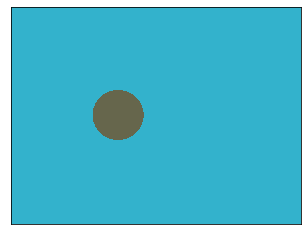

In [8]:
%matplotlib inline

import cv2
from matplotlib import pyplot as plt
import numpy as np

img = cv2.imread('imgs/out2.ppm')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

***
## Step 3: add more spheres


In [9]:
%%writefile src/main3.cpp

#include <limits>
#include <cmath>
#include <iostream>
#include <fstream>
#include <vector>

#include <CL/sycl.hpp>

#include "geometry.h"

struct Material {
    Material(const Vec3f &color) : diffuse_color(color) {}
    Material() : diffuse_color() {}
    Vec3f diffuse_color;
};
    
struct Sphere {
    Vec3f center;
    float radius;
    Material material;

    Sphere(const Vec3f &c, const float &r, const Material &m) : center(c), radius(r), material(m) {}

    bool ray_intersect(const Vec3f &orig, const Vec3f &dir, float &t0) const {
        Vec3f L = center - orig;
        float tca = L*dir;
        float d2 = L*L - tca*tca;
        if (d2 > radius*radius) return false;
        float thc = sqrtf(radius*radius - d2);
        t0       = tca - thc;
        float t1 = tca + thc;
        if (t0 < 0) t0 = t1;
        if (t0 < 0) return false;
        return true;
        }
};

bool scene_intersect(const Vec3f &orig, const Vec3f &dir, const std::vector<Sphere> &spheres, Vec3f &hit, Vec3f &N, Material &material) {
    float spheres_dist = std::numeric_limits<float>::max();
    for (size_t i=0; i < spheres.size(); i++) {
        float dist_i;
        if (spheres[i].ray_intersect(orig, dir, dist_i) && dist_i < spheres_dist) {
            spheres_dist = dist_i;
            hit = orig + dir*dist_i;
            N = (hit - spheres[i].center).normalize();
            material = spheres[i].material;
        }
    }
    return spheres_dist<1000;
}

Vec3f cast_ray(const Vec3f &orig, const Vec3f &dir, const std::vector<Sphere> &spheres) {
    Vec3f point, N;
    Material material;

    if (!scene_intersect(orig, dir, spheres, point, N, material)) {
        return Vec3f(0.2, 0.7, 0.8); // background color
    }
    
    return material.diffuse_color;
}



void render(const std::vector<Sphere> &spheres) {

    const int width    = 1024;
    const int height   = 768;
    const int fov      = M_PI/2.;

    std::vector<Vec3f> framebuffer(width*height);

    #pragma omp parallel for
    for (size_t j = 0; j<height; j++) {
        for (size_t i = 0; i<width; i++) {
            float x =  (2*(i + 0.5)/(float)width  - 1)*tan(fov/2.)*width/(float)height;
            float y = -(2*(j + 0.5)/(float)height - 1)*tan(fov/2.);
            Vec3f dir = Vec3f(x, y, -1).normalize();
            framebuffer[i+j*width] = cast_ray(Vec3f(0,0,0), dir, spheres);
        }
    }

    std::ofstream ofs; // save the framebuffer to file
    ofs.open("imgs/out3.ppm");
    ofs << "P6\n" << width << " " << height << "\n255\n";
    for (size_t i = 0; i < height*width; ++i) {
        for (size_t j = 0; j<3; j++) {
            ofs << (char)(255 * std::max(0.f, std::min(1.f, framebuffer[i][j])));
        }
    }
    ofs.close();
}

int main() {
    Material ivory(Vec3f(0.4, 0.4, 0.3));
    Material red_rubber(Vec3f(0.3, 0.1, 0.1));

    std::vector<Sphere> spheres;
    spheres.push_back(Sphere(Vec3f(-3,    0,   -16), 2,      ivory));
    spheres.push_back(Sphere(Vec3f(-1.0, -1.5, -12), 2, red_rubber));
    spheres.push_back(Sphere(Vec3f( 1.5, -0.5, -18), 3, red_rubber));
    spheres.push_back(Sphere(Vec3f( 7,    5,   -18), 4,      ivory));

    render(spheres);

    return 0;
}

Overwriting src/main3.cpp


In [10]:
! dpcpp src/main3.cpp -I./include -o ./bin/main3 -fopenmp -std=c++11 -lglog

In [11]:
! bin/main3

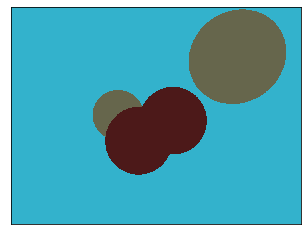

In [12]:
%matplotlib inline

import cv2
from matplotlib import pyplot as plt
import numpy as np

img = cv2.imread('imgs/out3.ppm')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

***
## Step 4: lighting


In [13]:
%%writefile src/main4.cpp

#include <limits>
#include <cmath>
#include <iostream>
#include <fstream>
#include <vector>

#include <CL/sycl.hpp>

#include "geometry.h"

struct Light {
    Light(const Vec3f &p, const float &i) : position(p), intensity(i) {}
    Vec3f position;
    float intensity;
};

struct Material {
    Material(const Vec3f &color) : diffuse_color(color) {}
    Material() : diffuse_color() {}
    Vec3f diffuse_color;
};
    
struct Sphere {
    Vec3f center;
    float radius;
    Material material;

    Sphere(const Vec3f &c, const float &r, const Material &m) : center(c), radius(r), material(m) {}

    bool ray_intersect(const Vec3f &orig, const Vec3f &dir, float &t0) const {
        Vec3f L = center - orig;
        float tca = L*dir;
        float d2 = L*L - tca*tca;
        if (d2 > radius*radius) return false;
        float thc = sqrtf(radius*radius - d2);
        t0       = tca - thc;
        float t1 = tca + thc;
        if (t0 < 0) t0 = t1;
        if (t0 < 0) return false;
        return true;
        }
};

bool scene_intersect(const Vec3f &orig, const Vec3f &dir, const std::vector<Sphere> &spheres, Vec3f &hit, Vec3f &N, Material &material) {
    float spheres_dist = std::numeric_limits<float>::max();
    for (size_t i=0; i < spheres.size(); i++) {
        float dist_i;
        if (spheres[i].ray_intersect(orig, dir, dist_i) && dist_i < spheres_dist) {
            spheres_dist = dist_i;
            hit = orig + dir*dist_i;
            N = (hit - spheres[i].center).normalize();
            material = spheres[i].material;
        }
    }
    return spheres_dist<1000;
}

Vec3f cast_ray(const Vec3f &orig, const Vec3f &dir, const std::vector<Sphere> &spheres, const std::vector<Light> &lights) {
    Vec3f point, N;
    Material material;

    if (!scene_intersect(orig, dir, spheres, point, N, material)) {
        return Vec3f(0.2, 0.7, 0.8); // background color
    }
    
    float diffuse_light_intensity = 0;
    for (size_t i=0; i<lights.size(); i++) {
        Vec3f light_dir      = (lights[i].position - point).normalize();
        diffuse_light_intensity  += lights[i].intensity * std::max(0.f, light_dir*N);
    }
    return material.diffuse_color * diffuse_light_intensity;
}

void render(const std::vector<Sphere> &spheres, const std::vector<Light> &lights) {

    const int width    = 1024;
    const int height   = 768;
    const int fov      = M_PI/2.;

    std::vector<Vec3f> framebuffer(width*height);

    #pragma omp parallel for
    for (size_t j = 0; j<height; j++) {
        for (size_t i = 0; i<width; i++) {
            float x =  (2*(i + 0.5)/(float)width  - 1)*tan(fov/2.)*width/(float)height;
            float y = -(2*(j + 0.5)/(float)height - 1)*tan(fov/2.);
            Vec3f dir = Vec3f(x, y, -1).normalize();
            framebuffer[i+j*width] = cast_ray(Vec3f(0,0,0), dir, spheres, lights);
        }
    }

    std::ofstream ofs; // save the framebuffer to file
    ofs.open("imgs/out4.ppm");
    ofs << "P6\n" << width << " " << height << "\n255\n";
    for (size_t i = 0; i < height*width; ++i) {
        for (size_t j = 0; j<3; j++) {
            ofs << (char)(255 * std::max(0.f, std::min(1.f, framebuffer[i][j])));
        }
    }
    ofs.close();
}

int main() {
    Material ivory(Vec3f(0.4, 0.4, 0.3));
    Material red_rubber(Vec3f(0.3, 0.1, 0.1));

    std::vector<Sphere> spheres;
    spheres.push_back(Sphere(Vec3f(-3,    0,   -16), 2,      ivory));
    spheres.push_back(Sphere(Vec3f(-1.0, -1.5, -12), 2, red_rubber));
    spheres.push_back(Sphere(Vec3f( 1.5, -0.5, -18), 3, red_rubber));
    spheres.push_back(Sphere(Vec3f( 7,    5,   -18), 4,      ivory));

    std::vector<Light>  lights;
    lights.push_back(Light(Vec3f(-20, 20,  20), 1.5));

    render(spheres, lights);

    return 0;
}

Overwriting src/main4.cpp


In [14]:
! dpcpp src/main4.cpp -I./include -o ./bin/main4 -fopenmp -std=c++11 -lglog

In [15]:
! bin/main4

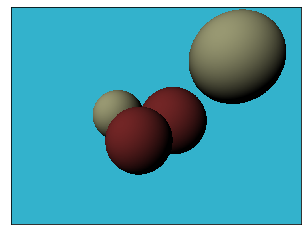

In [16]:
%matplotlib inline

import cv2
from matplotlib import pyplot as plt
import numpy as np

img = cv2.imread('imgs/out4.ppm')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

***
## Step 5: specular lighting

In [17]:
%%writefile src/main5.cpp

#include <limits>
#include <cmath>
#include <iostream>
#include <fstream>
#include <vector>

#include <CL/sycl.hpp>

#include "geometry.h"

struct Light {
    Light(const Vec3f &p, const float &i) : position(p), intensity(i) {}
    Vec3f position;
    float intensity;
};

struct Material {
    Material(const Vec2f &a, const Vec3f &color, const float &spec) : albedo(a), diffuse_color(color), specular_exponent(spec) {}
    Material() : albedo(1,0), diffuse_color(), specular_exponent() {}
    Vec2f albedo;
    Vec3f diffuse_color;
    float specular_exponent;
};
    
struct Sphere {
    Vec3f center;
    float radius;
    Material material;

    Sphere(const Vec3f &c, const float &r, const Material &m) : center(c), radius(r), material(m) {}

    bool ray_intersect(const Vec3f &orig, const Vec3f &dir, float &t0) const {
        Vec3f L = center - orig;
        float tca = L*dir;
        float d2 = L*L - tca*tca;
        if (d2 > radius*radius) return false;
        float thc = sqrtf(radius*radius - d2);
        t0       = tca - thc;
        float t1 = tca + thc;
        if (t0 < 0) t0 = t1;
        if (t0 < 0) return false;
        return true;
        }
};

bool scene_intersect(const Vec3f &orig, const Vec3f &dir, const std::vector<Sphere> &spheres, Vec3f &hit, Vec3f &N, Material &material) {
    float spheres_dist = std::numeric_limits<float>::max();
    for (size_t i=0; i < spheres.size(); i++) {
        float dist_i;
        if (spheres[i].ray_intersect(orig, dir, dist_i) && dist_i < spheres_dist) {
            spheres_dist = dist_i;
            hit = orig + dir*dist_i;
            N = (hit - spheres[i].center).normalize();
            material = spheres[i].material;
        }
    }
    return spheres_dist<1000;
}


Vec3f reflect(const Vec3f &I, const Vec3f &N) {
    return I - N*2.f*(I*N);
}

Vec3f cast_ray(const Vec3f &orig, const Vec3f &dir, const std::vector<Sphere> &spheres, const std::vector<Light> &lights) {
    Vec3f point, N;
    Material material;

    if (!scene_intersect(orig, dir, spheres, point, N, material)) {
        return Vec3f(0.2, 0.7, 0.8); // background color
    }
    
    float diffuse_light_intensity = 0, specular_light_intensity = 0;
    for (size_t i=0; i<lights.size(); i++) {
        Vec3f light_dir      = (lights[i].position - point).normalize();
        diffuse_light_intensity  += lights[i].intensity * std::max(0.f, light_dir*N);
    }
    return material.diffuse_color * diffuse_light_intensity * material.albedo[0] + Vec3f(1., 1., 1.)*specular_light_intensity * material.albedo[1];
}

void render(const std::vector<Sphere> &spheres, const std::vector<Light> &lights) {

    const int width    = 1024;
    const int height   = 768;
    const int fov      = M_PI/2.;

    std::vector<Vec3f> framebuffer(width*height);

    #pragma omp parallel for
    for (size_t j = 0; j<height; j++) {
        for (size_t i = 0; i<width; i++) {
            float x =  (2*(i + 0.5)/(float)width  - 1)*tan(fov/2.)*width/(float)height;
            float y = -(2*(j + 0.5)/(float)height - 1)*tan(fov/2.);
            Vec3f dir = Vec3f(x, y, -1).normalize();
            framebuffer[i+j*width] = cast_ray(Vec3f(0,0,0), dir, spheres, lights);
        }
    }

    std::ofstream ofs; // save the framebuffer to file
    ofs.open("imgs/out5.ppm");
    ofs << "P6\n" << width << " " << height << "\n255\n";
    for (size_t i = 0; i < height*width; ++i) {
        Vec3f &c = framebuffer[i];
        float max = std::max(c[0], std::max(c[1], c[2]));
        if (max>1) c = c*(1./max);
        for (size_t j = 0; j<3; j++) {
            ofs << (char)(255 * std::max(0.f, std::min(1.f, framebuffer[i][j])));
        }
    }
    ofs.close();
}

int main() {
    Material      ivory(Vec2f(0.6,  0.3), Vec3f(0.4, 0.4, 0.3),   50.);
    Material red_rubber(Vec2f(0.9,  0.1), Vec3f(0.3, 0.1, 0.1),   10.);

    std::vector<Sphere> spheres;
    spheres.push_back(Sphere(Vec3f(-3,    0,   -16), 2,      ivory));
    spheres.push_back(Sphere(Vec3f(-1.0, -1.5, -12), 2, red_rubber));
    spheres.push_back(Sphere(Vec3f( 1.5, -0.5, -18), 3, red_rubber));
    spheres.push_back(Sphere(Vec3f( 7,    5,   -18), 4,      ivory));

    std::vector<Light>  lights;
    lights.push_back(Light(Vec3f(-20, 20,  20), 1.5));
    lights.push_back(Light(Vec3f( 30, 50, -25), 1.8));
    lights.push_back(Light(Vec3f( 30, 20,  30), 1.7));

    render(spheres, lights);

    return 0;
}

Overwriting src/main5.cpp


In [18]:
! dpcpp src/main5.cpp -I./include -o ./bin/main5 -fopenmp -std=c++11 -lglog

In [19]:
! bin/main5

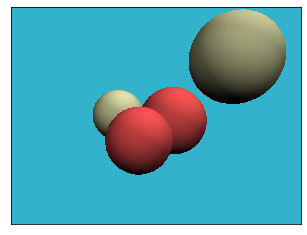

In [20]:
%matplotlib inline

import cv2
from matplotlib import pyplot as plt
import numpy as np

img = cv2.imread('imgs/out5.ppm')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

***
## Step 6: shadows

In [21]:
%%writefile src/main6.cpp

#include <limits>
#include <cmath>
#include <iostream>
#include <fstream>
#include <vector>

#include <CL/sycl.hpp>

#include "geometry.h"

struct Light {
    Light(const Vec3f &p, const float &i) : position(p), intensity(i) {}
    Vec3f position;
    float intensity;
};

struct Material {
    Material(const Vec2f &a, const Vec3f &color, const float &spec) : albedo(a), diffuse_color(color), specular_exponent(spec) {}
    Material() : albedo(1,0), diffuse_color(), specular_exponent() {}
    Vec2f albedo;
    Vec3f diffuse_color;
    float specular_exponent;
};
    
struct Sphere {
    Vec3f center;
    float radius;
    Material material;

    Sphere(const Vec3f &c, const float &r, const Material &m) : center(c), radius(r), material(m) {}

    bool ray_intersect(const Vec3f &orig, const Vec3f &dir, float &t0) const {
        Vec3f L = center - orig;
        float tca = L*dir;
        float d2 = L*L - tca*tca;
        if (d2 > radius*radius) return false;
        float thc = sqrtf(radius*radius - d2);
        t0       = tca - thc;
        float t1 = tca + thc;
        if (t0 < 0) t0 = t1;
        if (t0 < 0) return false;
        return true;
        }
};

bool scene_intersect(const Vec3f &orig, const Vec3f &dir, const std::vector<Sphere> &spheres, Vec3f &hit, Vec3f &N, Material &material) {
    float spheres_dist = std::numeric_limits<float>::max();
    for (size_t i=0; i < spheres.size(); i++) {
        float dist_i;
        if (spheres[i].ray_intersect(orig, dir, dist_i) && dist_i < spheres_dist) {
            spheres_dist = dist_i;
            hit = orig + dir*dist_i;
            N = (hit - spheres[i].center).normalize();
            material = spheres[i].material;
        }
    }
    return spheres_dist<1000;
}


Vec3f reflect(const Vec3f &I, const Vec3f &N) {
    return I - N*2.f*(I*N);
}

Vec3f cast_ray(const Vec3f &orig, const Vec3f &dir, const std::vector<Sphere> &spheres, const std::vector<Light> &lights) {
    Vec3f point, N;
    Material material;

    if (!scene_intersect(orig, dir, spheres, point, N, material)) {
        return Vec3f(0.2, 0.7, 0.8); // background color
    }
    
    float diffuse_light_intensity = 0, specular_light_intensity = 0;
    for (size_t i=0; i<lights.size(); i++) {
        Vec3f light_dir      = (lights[i].position - point).normalize();
        float light_distance = (lights[i].position - point).norm();

        Vec3f shadow_orig = light_dir*N < 0 ? point - N*1e-3 : point + N*1e-3; // checking if the point lies in the shadow of the lights[i]
        Vec3f shadow_pt, shadow_N;
        Material tmpmaterial;
        if (scene_intersect(shadow_orig, light_dir, spheres, shadow_pt, shadow_N, tmpmaterial) && (shadow_pt-shadow_orig).norm() < light_distance)
            continue;
        diffuse_light_intensity  += lights[i].intensity * std::max(0.f, light_dir*N);
    }
    return material.diffuse_color * diffuse_light_intensity * material.albedo[0] + Vec3f(1., 1., 1.)*specular_light_intensity * material.albedo[1];
}

void render(const std::vector<Sphere> &spheres, const std::vector<Light> &lights) {

    const int width    = 1024;
    const int height   = 768;
    const int fov      = M_PI/2.;

    std::vector<Vec3f> framebuffer(width*height);

    #pragma omp parallel for
    for (size_t j = 0; j<height; j++) {
        for (size_t i = 0; i<width; i++) {
            float x =  (2*(i + 0.5)/(float)width  - 1)*tan(fov/2.)*width/(float)height;
            float y = -(2*(j + 0.5)/(float)height - 1)*tan(fov/2.);
            Vec3f dir = Vec3f(x, y, -1).normalize();
            framebuffer[i+j*width] = cast_ray(Vec3f(0,0,0), dir, spheres, lights);
        }
    }

    std::ofstream ofs; // save the framebuffer to file
    ofs.open("imgs/out6.ppm");
    ofs << "P6\n" << width << " " << height << "\n255\n";
    for (size_t i = 0; i < height*width; ++i) {
        Vec3f &c = framebuffer[i];
        float max = std::max(c[0], std::max(c[1], c[2]));
        if (max>1) c = c*(1./max);
        for (size_t j = 0; j<3; j++) {
            ofs << (char)(255 * std::max(0.f, std::min(1.f, framebuffer[i][j])));
        }
    }
    ofs.close();
}

int main() {
    Material      ivory(Vec2f(0.6,  0.3), Vec3f(0.4, 0.4, 0.3),   50.);
    Material red_rubber(Vec2f(0.9,  0.1), Vec3f(0.3, 0.1, 0.1),   10.);

    std::vector<Sphere> spheres;
    spheres.push_back(Sphere(Vec3f(-3,    0,   -16), 2,      ivory));
    spheres.push_back(Sphere(Vec3f(-1.0, -1.5, -12), 2, red_rubber));
    spheres.push_back(Sphere(Vec3f( 1.5, -0.5, -18), 3, red_rubber));
    spheres.push_back(Sphere(Vec3f( 7,    5,   -18), 4,      ivory));

    std::vector<Light>  lights;
    lights.push_back(Light(Vec3f(-20, 20,  20), 1.5));
    lights.push_back(Light(Vec3f( 30, 50, -25), 1.8));
    lights.push_back(Light(Vec3f( 30, 20,  30), 1.7));

    render(spheres, lights);

    return 0;
}

Overwriting src/main6.cpp


In [22]:
! dpcpp src/main6.cpp -I./include -o ./bin/main6 -fopenmp -std=c++11 -lglog

In [23]:
! bin/main6

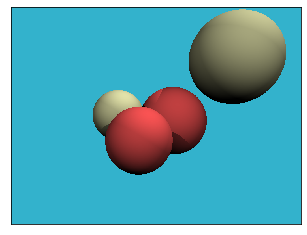

In [24]:
%matplotlib inline

import cv2
from matplotlib import pyplot as plt
import numpy as np

img = cv2.imread('imgs/out6.ppm')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis

plt.show()

***
## Step 7: reflections


In [25]:
%%writefile src/main7.cpp

#include <limits>
#include <cmath>
#include <iostream>
#include <fstream>
#include <vector>

#include <CL/sycl.hpp>

#include "geometry.h"

struct Light {
    Light(const Vec3f &p, const float &i) : position(p), intensity(i) {}
    Vec3f position;
    float intensity;
};

struct Material {
    Material(const Vec3f &a, const Vec3f &color, const float &spec) : albedo(a), diffuse_color(color), specular_exponent(spec) {}
    Material() : albedo(1,0,0), diffuse_color(), specular_exponent() {}
    Vec3f albedo;
    Vec3f diffuse_color;
    float specular_exponent;
};
    
struct Sphere {
    Vec3f center;
    float radius;
    Material material;

    Sphere(const Vec3f &c, const float &r, const Material &m) : center(c), radius(r), material(m) {}

    bool ray_intersect(const Vec3f &orig, const Vec3f &dir, float &t0) const {
        Vec3f L = center - orig;
        float tca = L*dir;
        float d2 = L*L - tca*tca;
        if (d2 > radius*radius) return false;
        float thc = sqrtf(radius*radius - d2);
        t0       = tca - thc;
        float t1 = tca + thc;
        if (t0 < 0) t0 = t1;
        if (t0 < 0) return false;
        return true;
        }
};

bool scene_intersect(const Vec3f &orig, const Vec3f &dir, const std::vector<Sphere> &spheres, Vec3f &hit, Vec3f &N, Material &material) {
    float spheres_dist = std::numeric_limits<float>::max();
    for (size_t i=0; i < spheres.size(); i++) {
        float dist_i;
        if (spheres[i].ray_intersect(orig, dir, dist_i) && dist_i < spheres_dist) {
            spheres_dist = dist_i;
            hit = orig + dir*dist_i;
            N = (hit - spheres[i].center).normalize();
            material = spheres[i].material;
        }
    }
    return spheres_dist<1000;
}


Vec3f reflect(const Vec3f &I, const Vec3f &N) {
    return I - N*2.f*(I*N);
}

Vec3f cast_ray(const Vec3f &orig, const Vec3f &dir, const std::vector<Sphere> &spheres, const std::vector<Light> &lights, size_t depth=0) {
    Vec3f point, N;
    Material material;

    if (depth>4 || !scene_intersect(orig, dir, spheres, point, N, material)) {
        return Vec3f(0.2, 0.7, 0.8); // background color
    }
    
    Vec3f reflect_dir = reflect(dir, N).normalize();
    Vec3f reflect_orig = reflect_dir*N < 0 ? point - N*1e-3 : point + N*1e-3; // offset the original point to avoid occlusion by the object itself
    Vec3f reflect_color = cast_ray(reflect_orig, reflect_dir, spheres, lights, depth + 1);
    
    float diffuse_light_intensity = 0, specular_light_intensity = 0;
    for (size_t i=0; i<lights.size(); i++) {
        Vec3f light_dir      = (lights[i].position - point).normalize();
        float light_distance = (lights[i].position - point).norm();

        Vec3f shadow_orig = light_dir*N < 0 ? point - N*1e-3 : point + N*1e-3; // checking if the point lies in the shadow of the lights[i]
        Vec3f shadow_pt, shadow_N;
        Material tmpmaterial;
        if (scene_intersect(shadow_orig, light_dir, spheres, shadow_pt, shadow_N, tmpmaterial) && (shadow_pt-shadow_orig).norm() < light_distance)
            continue;
        diffuse_light_intensity  += lights[i].intensity * std::max(0.f, light_dir*N);
    }
    return material.diffuse_color * diffuse_light_intensity * material.albedo[0] + Vec3f(1., 1., 1.)*specular_light_intensity * material.albedo[1] + reflect_color*material.albedo[2];
}

void render(const std::vector<Sphere> &spheres, const std::vector<Light> &lights) {

    const int width    = 1024;
    const int height   = 768;
    const int fov      = M_PI/2.;

    std::vector<Vec3f> framebuffer(width*height);

    #pragma omp parallel for
    for (size_t j = 0; j<height; j++) {
        for (size_t i = 0; i<width; i++) {
            float x =  (2*(i + 0.5)/(float)width  - 1)*tan(fov/2.)*width/(float)height;
            float y = -(2*(j + 0.5)/(float)height - 1)*tan(fov/2.);
            Vec3f dir = Vec3f(x, y, -1).normalize();
            framebuffer[i+j*width] = cast_ray(Vec3f(0,0,0), dir, spheres, lights);
        }
    }

    std::ofstream ofs; // save the framebuffer to file
    ofs.open("imgs/out7.ppm");
    ofs << "P6\n" << width << " " << height << "\n255\n";
    for (size_t i = 0; i < height*width; ++i) {
        Vec3f &c = framebuffer[i];
        float max = std::max(c[0], std::max(c[1], c[2]));
        if (max>1) c = c*(1./max);
        for (size_t j = 0; j<3; j++) {
            ofs << (char)(255 * std::max(0.f, std::min(1.f, framebuffer[i][j])));
        }
    }
    ofs.close();
}

int main() {
    Material      ivory(Vec3f(0.6,  0.3, 0.1), Vec3f(0.4, 0.4, 0.3),   50.);
    Material red_rubber(Vec3f(0.9,  0.1, 0.0), Vec3f(0.3, 0.1, 0.1),   10.);
    Material     mirror(Vec3f(0.0, 10.0, 0.8), Vec3f(1.0, 1.0, 1.0), 1425.);

    std::vector<Sphere> spheres;
    spheres.push_back(Sphere(Vec3f(-3,    0,   -16), 2,      ivory));
    spheres.push_back(Sphere(Vec3f(-1.0, -1.5, -12), 2,      mirror));
    spheres.push_back(Sphere(Vec3f( 1.5, -0.5, -18), 3, red_rubber));
    spheres.push_back(Sphere(Vec3f( 7,    5,   -18), 4,     mirror));

    std::vector<Light>  lights;
    lights.push_back(Light(Vec3f(-20, 20,  20), 1.5));
    lights.push_back(Light(Vec3f( 30, 50, -25), 1.8));
    lights.push_back(Light(Vec3f( 30, 20,  30), 1.7));

    render(spheres, lights);

    return 0;
}

Overwriting src/main7.cpp


In [26]:
! dpcpp src/main7.cpp -I./include -o ./bin/main7 -fopenmp -std=c++11 -lglog

In [27]:
! bin/main7

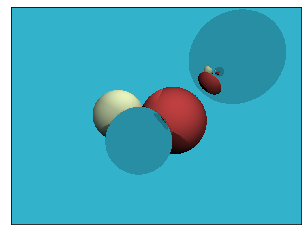

In [28]:
%matplotlib inline

import cv2
from matplotlib import pyplot as plt
import numpy as np

img = cv2.imread('imgs/out7.ppm')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

***
## Step 8: refractions


In [29]:
%%writefile src/main8.cpp

#include <limits>
#include <cmath>
#include <iostream>
#include <fstream>
#include <vector>

#include <CL/sycl.hpp>

#include "geometry.h"

struct Light {
    Light(const Vec3f &p, const float &i) : position(p), intensity(i) {}
    Vec3f position;
    float intensity;
};

struct Material {
    Material(const float &r, const Vec4f &a, const Vec3f &color, const float &spec) : refractive_index(r), albedo(a), diffuse_color(color), specular_exponent(spec) {}
    Material() : refractive_index(1), albedo(1,0,0,0), diffuse_color(), specular_exponent() {}
    float refractive_index;
    Vec4f albedo;
    Vec3f diffuse_color;
    float specular_exponent;
};
    
struct Sphere {
    Vec3f center;
    float radius;
    Material material;

    Sphere(const Vec3f &c, const float &r, const Material &m) : center(c), radius(r), material(m) {}

    bool ray_intersect(const Vec3f &orig, const Vec3f &dir, float &t0) const {
        Vec3f L = center - orig;
        float tca = L*dir;
        float d2 = L*L - tca*tca;
        if (d2 > radius*radius) return false;
        float thc = sqrtf(radius*radius - d2);
        t0       = tca - thc;
        float t1 = tca + thc;
        if (t0 < 0) t0 = t1;
        if (t0 < 0) return false;
        return true;
        }
};


Vec3f refract(const Vec3f &I, const Vec3f &N, const float &refractive_index) { // Snell's law
    float cosi = - std::max(-1.f, std::min(1.f, I*N));
    float etai = 1, etat = refractive_index;
    Vec3f n = N;
    if (cosi < 0) { // if the ray is inside the object, swap the indices and invert the normal to get the correct result
        cosi = -cosi;
        std::swap(etai, etat); n = -N;
    }
    float eta = etai / etat;
    float k = 1 - eta*eta*(1 - cosi*cosi);
    return k < 0 ? Vec3f(0,0,0) : I*eta + n*(eta * cosi - sqrtf(k));
}

bool scene_intersect(const Vec3f &orig, const Vec3f &dir, const std::vector<Sphere> &spheres, Vec3f &hit, Vec3f &N, Material &material) {
    float spheres_dist = std::numeric_limits<float>::max();
    for (size_t i=0; i < spheres.size(); i++) {
        float dist_i;
        if (spheres[i].ray_intersect(orig, dir, dist_i) && dist_i < spheres_dist) {
            spheres_dist = dist_i;
            hit = orig + dir*dist_i;
            N = (hit - spheres[i].center).normalize();
            material = spheres[i].material;
        }
    }
    return spheres_dist<1000;
}


Vec3f reflect(const Vec3f &I, const Vec3f &N) {
    return I - N*2.f*(I*N);
}

Vec3f cast_ray(const Vec3f &orig, const Vec3f &dir, const std::vector<Sphere> &spheres, const std::vector<Light> &lights, size_t depth=0) {
    Vec3f point, N;
    Material material;

    if (depth>4 || !scene_intersect(orig, dir, spheres, point, N, material)) {
        return Vec3f(0.2, 0.7, 0.8); // background color
    }
    
    Vec3f reflect_dir = reflect(dir, N).normalize();
    Vec3f refract_dir = refract(dir, N, material.refractive_index).normalize();

    Vec3f reflect_orig = reflect_dir*N < 0 ? point - N*1e-3 : point + N*1e-3; // offset the original point to avoid occlusion by the object itself
    Vec3f refract_orig = refract_dir*N < 0 ? point - N*1e-3 : point + N*1e-3;

    Vec3f reflect_color = cast_ray(reflect_orig, reflect_dir, spheres, lights, depth + 1);
    Vec3f refract_color = cast_ray(refract_orig, refract_dir, spheres, lights, depth + 1);

    
    float diffuse_light_intensity = 0, specular_light_intensity = 0;
    for (size_t i=0; i<lights.size(); i++) {
        Vec3f light_dir      = (lights[i].position - point).normalize();
        float light_distance = (lights[i].position - point).norm();

        Vec3f shadow_orig = light_dir*N < 0 ? point - N*1e-3 : point + N*1e-3; // checking if the point lies in the shadow of the lights[i]
        Vec3f shadow_pt, shadow_N;
        Material tmpmaterial;
        if (scene_intersect(shadow_orig, light_dir, spheres, shadow_pt, shadow_N, tmpmaterial) && (shadow_pt-shadow_orig).norm() < light_distance)
            continue;
        diffuse_light_intensity  += lights[i].intensity * std::max(0.f, light_dir*N);
    }
    return material.diffuse_color * diffuse_light_intensity * material.albedo[0] + Vec3f(1., 1., 1.)*specular_light_intensity * material.albedo[1] + reflect_color*material.albedo[2] + refract_color*material.albedo[3];
}

void render(const std::vector<Sphere> &spheres, const std::vector<Light> &lights) {

    const int width    = 1024;
    const int height   = 768;
    const int fov      = M_PI/2.;

    std::vector<Vec3f> framebuffer(width*height);

    #pragma omp parallel for
    for (size_t j = 0; j<height; j++) {
        for (size_t i = 0; i<width; i++) {
            float x =  (2*(i + 0.5)/(float)width  - 1)*tan(fov/2.)*width/(float)height;
            float y = -(2*(j + 0.5)/(float)height - 1)*tan(fov/2.);
            Vec3f dir = Vec3f(x, y, -1).normalize();
            framebuffer[i+j*width] = cast_ray(Vec3f(0,0,0), dir, spheres, lights);
        }
    }

    std::ofstream ofs; // save the framebuffer to file
    ofs.open("imgs/out8.ppm");
    ofs << "P6\n" << width << " " << height << "\n255\n";
    for (size_t i = 0; i < height*width; ++i) {
        Vec3f &c = framebuffer[i];
        float max = std::max(c[0], std::max(c[1], c[2]));
        if (max>1) c = c*(1./max);
        for (size_t j = 0; j<3; j++) {
            ofs << (char)(255 * std::max(0.f, std::min(1.f, framebuffer[i][j])));
        }
    }
    ofs.close();
}

int main() {
    Material      ivory(1.0, Vec4f(0.6,  0.3, 0.1, 0.0), Vec3f(0.4, 0.4, 0.3),   50.);
    Material      glass(1.5, Vec4f(0.0,  0.5, 0.1, 0.8), Vec3f(0.6, 0.7, 0.8),  125.);
    Material red_rubber(1.0, Vec4f(0.9,  0.1, 0.0, 0.0), Vec3f(0.3, 0.1, 0.1),   10.);
    Material     mirror(1.0, Vec4f(0.0, 10.0, 0.8, 0.0), Vec3f(1.0, 1.0, 1.0), 1425.);

    std::vector<Sphere> spheres;
    spheres.push_back(Sphere(Vec3f(-3,    0,   -16), 2,      ivory));
        spheres.push_back(Sphere(Vec3f(-1.0, -1.5, -12), 2,      glass));
    spheres.push_back(Sphere(Vec3f( 1.5, -0.5, -18), 3, red_rubber));
    spheres.push_back(Sphere(Vec3f( 7,    5,   -18), 4,     mirror));

    std::vector<Light>  lights;
    lights.push_back(Light(Vec3f(-20, 20,  20), 1.5));
    lights.push_back(Light(Vec3f( 30, 50, -25), 1.8));
    lights.push_back(Light(Vec3f( 30, 20,  30), 1.7));

    render(spheres, lights);

    return 0;
}

Overwriting src/main8.cpp


In [30]:
! dpcpp src/main8.cpp -I./include -o ./bin/main8 -fopenmp -std=c++11 -lglog

In [31]:
! bin/main8

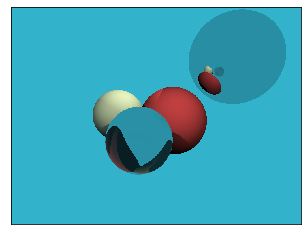

In [32]:
%matplotlib inline

import cv2
from matplotlib import pyplot as plt
import numpy as np

img = cv2.imread('imgs/out8.ppm')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

***
## Step 9:  beyond spheres

In [33]:
%%writefile src/main9.cpp

#include <limits>
#include <cmath>
#include <iostream>
#include <fstream>
#include <vector>

#include <CL/sycl.hpp>

#include "geometry.h"

struct Light {
    Light(const Vec3f &p, const float &i) : position(p), intensity(i) {}
    Vec3f position;
    float intensity;
};

struct Material {
    Material(const float &r, const Vec4f &a, const Vec3f &color, const float &spec) : refractive_index(r), albedo(a), diffuse_color(color), specular_exponent(spec) {}
    Material() : refractive_index(1), albedo(1,0,0,0), diffuse_color(), specular_exponent() {}
    float refractive_index;
    Vec4f albedo;
    Vec3f diffuse_color;
    float specular_exponent;
};
    
struct Sphere {
    Vec3f center;
    float radius;
    Material material;

    Sphere(const Vec3f &c, const float &r, const Material &m) : center(c), radius(r), material(m) {}

    bool ray_intersect(const Vec3f &orig, const Vec3f &dir, float &t0) const {
        Vec3f L = center - orig;
        float tca = L*dir;
        float d2 = L*L - tca*tca;
        if (d2 > radius*radius) return false;
        float thc = sqrtf(radius*radius - d2);
        t0       = tca - thc;
        float t1 = tca + thc;
        if (t0 < 0) t0 = t1;
        if (t0 < 0) return false;
        return true;
        }
};


Vec3f refract(const Vec3f &I, const Vec3f &N, const float &refractive_index) { // Snell's law
    float cosi = - std::max(-1.f, std::min(1.f, I*N));
    float etai = 1, etat = refractive_index;
    Vec3f n = N;
    if (cosi < 0) { // if the ray is inside the object, swap the indices and invert the normal to get the correct result
        cosi = -cosi;
        std::swap(etai, etat); n = -N;
    }
    float eta = etai / etat;
    float k = 1 - eta*eta*(1 - cosi*cosi);
    return k < 0 ? Vec3f(0,0,0) : I*eta + n*(eta * cosi - sqrtf(k));
}

bool scene_intersect(const Vec3f &orig, const Vec3f &dir, const std::vector<Sphere> &spheres, Vec3f &hit, Vec3f &N, Material &material) {
    float spheres_dist = std::numeric_limits<float>::max();
    for (size_t i=0; i < spheres.size(); i++) {
        float dist_i;
        if (spheres[i].ray_intersect(orig, dir, dist_i) && dist_i < spheres_dist) {
            spheres_dist = dist_i;
            hit = orig + dir*dist_i;
            N = (hit - spheres[i].center).normalize();
            material = spheres[i].material;
        }
    }
   
    float checkerboard_dist = std::numeric_limits<float>::max();
    if (fabs(dir.y)>1e-3)  {
        float d = -(orig.y+4)/dir.y; // the checkerboard plane has equation y = -4
        Vec3f pt = orig + dir*d;
        if (d>0 && fabs(pt.x)<10 && pt.z<-10 && pt.z>-30 && d<spheres_dist) {
            checkerboard_dist = d;
            hit = pt;
            N = Vec3f(0,1,0);
            material.diffuse_color = (int(.5*hit.x+1000) + int(.5*hit.z)) & 1 ? Vec3f(1,1,1) : Vec3f(1, .7, .3);
            material.diffuse_color = material.diffuse_color*.3;
        }
    }
    return std::min(spheres_dist, checkerboard_dist)<1000;
}


Vec3f reflect(const Vec3f &I, const Vec3f &N) {
    return I - N*2.f*(I*N);
}

Vec3f cast_ray(const Vec3f &orig, const Vec3f &dir, const std::vector<Sphere> &spheres, const std::vector<Light> &lights, size_t depth=0) {
    Vec3f point, N;
    Material material;

    if (depth>4 || !scene_intersect(orig, dir, spheres, point, N, material)) {
        return Vec3f(0.2, 0.7, 0.8); // background color
    }
    
    Vec3f reflect_dir = reflect(dir, N).normalize();
    Vec3f refract_dir = refract(dir, N, material.refractive_index).normalize();

    Vec3f reflect_orig = reflect_dir*N < 0 ? point - N*1e-3 : point + N*1e-3; // offset the original point to avoid occlusion by the object itself
    Vec3f refract_orig = refract_dir*N < 0 ? point - N*1e-3 : point + N*1e-3;

    Vec3f reflect_color = cast_ray(reflect_orig, reflect_dir, spheres, lights, depth + 1);
    Vec3f refract_color = cast_ray(refract_orig, refract_dir, spheres, lights, depth + 1);

    
    float diffuse_light_intensity = 0, specular_light_intensity = 0;
    for (size_t i=0; i<lights.size(); i++) {
        Vec3f light_dir      = (lights[i].position - point).normalize();
        float light_distance = (lights[i].position - point).norm();

        Vec3f shadow_orig = light_dir*N < 0 ? point - N*1e-3 : point + N*1e-3; // checking if the point lies in the shadow of the lights[i]
        Vec3f shadow_pt, shadow_N;
        Material tmpmaterial;
        if (scene_intersect(shadow_orig, light_dir, spheres, shadow_pt, shadow_N, tmpmaterial) && (shadow_pt-shadow_orig).norm() < light_distance)
            continue;
        diffuse_light_intensity  += lights[i].intensity * std::max(0.f, light_dir*N);
    }
    return material.diffuse_color * diffuse_light_intensity * material.albedo[0] + Vec3f(1., 1., 1.)*specular_light_intensity * material.albedo[1] + reflect_color*material.albedo[2] + refract_color*material.albedo[3];
}

void render(const std::vector<Sphere> &spheres, const std::vector<Light> &lights) {

    const int width    = 1024;
    const int height   = 768;
    const int fov      = M_PI/2.;

    std::vector<Vec3f> framebuffer(width*height);

    #pragma omp parallel for
    for (size_t j = 0; j<height; j++) {
        for (size_t i = 0; i<width; i++) {
            float x =  (2*(i + 0.5)/(float)width  - 1)*tan(fov/2.)*width/(float)height;
            float y = -(2*(j + 0.5)/(float)height - 1)*tan(fov/2.);
            Vec3f dir = Vec3f(x, y, -1).normalize();
            framebuffer[i+j*width] = cast_ray(Vec3f(0,0,0), dir, spheres, lights);
        }
    }

    std::ofstream ofs; // save the framebuffer to file
    ofs.open("imgs/out9.ppm");
    ofs << "P6\n" << width << " " << height << "\n255\n";
    for (size_t i = 0; i < height*width; ++i) {
        Vec3f &c = framebuffer[i];
        float max = std::max(c[0], std::max(c[1], c[2]));
        if (max>1) c = c*(1./max);
        for (size_t j = 0; j<3; j++) {
            ofs << (char)(255 * std::max(0.f, std::min(1.f, framebuffer[i][j])));
        }
    }
    ofs.close();
}

int main() {
    Material      ivory(1.0, Vec4f(0.6,  0.3, 0.1, 0.0), Vec3f(0.4, 0.4, 0.3),   50.);
    Material      glass(1.5, Vec4f(0.0,  0.5, 0.1, 0.8), Vec3f(0.6, 0.7, 0.8),  125.);
    Material red_rubber(1.0, Vec4f(0.9,  0.1, 0.0, 0.0), Vec3f(0.3, 0.1, 0.1),   10.);
    Material     mirror(1.0, Vec4f(0.0, 10.0, 0.8, 0.0), Vec3f(1.0, 1.0, 1.0), 1425.);

    std::vector<Sphere> spheres;
    spheres.push_back(Sphere(Vec3f(-3,    0,   -16), 2,      ivory));
        spheres.push_back(Sphere(Vec3f(-1.0, -1.5, -12), 2,      glass));
    spheres.push_back(Sphere(Vec3f( 1.5, -0.5, -18), 3, red_rubber));
    spheres.push_back(Sphere(Vec3f( 7,    5,   -18), 4,     mirror));

    std::vector<Light>  lights;
    lights.push_back(Light(Vec3f(-20, 20,  20), 1.5));
    lights.push_back(Light(Vec3f( 30, 50, -25), 1.8));
    lights.push_back(Light(Vec3f( 30, 20,  30), 1.7));

    render(spheres, lights);

    return 0;
}

Overwriting src/main9.cpp


In [34]:
! dpcpp src/main9.cpp -I./include -o ./bin/main9 -fopenmp -std=c++11 -lglog

In [35]:
! bin/main9

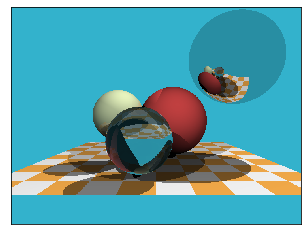

In [36]:
%matplotlib inline

import cv2
from matplotlib import pyplot as plt
import numpy as np

img = cv2.imread('imgs/out9.ppm')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

***
# Option 2:  Global Illumination via Path Tracing
From the Rendering team - smallpt approach in one candidate.  The radiance() function is a candidate for task- and data-parallelism.

### What is global illumination?
Global Illumination = “virtual photography”
Given a scene description that specifies the location of surfaces in a scene, the location of lights, and the location of a camera, take a virtual “photograph” of that scene.


## Lesson 1:  Analysis of the Beason approach - smallpt

In [37]:
%%writefile 'src/cpp-smallpt.cpp'

//-----------------------------------------------------------------------------
// Includes
//-----------------------------------------------------------------------------
#pragma region

#include "imageio.hpp"
#include "sampling.hpp"
#include "specular.hpp"
#include "sphere.hpp"

#pragma endregion

//-----------------------------------------------------------------------------
// System Includes
//-----------------------------------------------------------------------------
#pragma region

#include <iterator>
#include <memory>
#include <optional>

#pragma endregion

//-----------------------------------------------------------------------------
// Defines
//-----------------------------------------------------------------------------
#pragma region

#define REFRACTIVE_INDEX_OUT 1.0
#define REFRACTIVE_INDEX_IN  1.5

#pragma endregion

//-----------------------------------------------------------------------------
// Declarations and Definitions
//-----------------------------------------------------------------------------
namespace smallpt {

	constexpr Sphere g_spheres[] = {
		Sphere(1e5,  Vector3(1e5 + 1, 40.8, 81.6),   Vector3(),   Vector3(0.75,0.25,0.25), Reflection_t::Diffuse),	 //Left
		Sphere(1e5,  Vector3(-1e5 + 99, 40.8, 81.6), Vector3(),   Vector3(0.25,0.25,0.75), Reflection_t::Diffuse),	 //Right
		Sphere(1e5,  Vector3(50, 40.8, 1e5),         Vector3(),   Vector3(0.75),           Reflection_t::Diffuse),	 //Back
		Sphere(1e5,  Vector3(50, 40.8, -1e5 + 170),  Vector3(),   Vector3(),               Reflection_t::Diffuse),	 //Front
		Sphere(1e5,  Vector3(50, 1e5, 81.6),         Vector3(),   Vector3(0.75),           Reflection_t::Diffuse),	 //Bottom
		Sphere(1e5,  Vector3(50, -1e5 + 81.6, 81.6), Vector3(),   Vector3(0.75),           Reflection_t::Diffuse),	 //Top
		Sphere(16.5, Vector3(27, 16.5, 47),          Vector3(),   Vector3(0.999),          Reflection_t::Specular),	 //Mirror
		Sphere(16.5, Vector3(73, 16.5, 78),          Vector3(),   Vector3(0.999),          Reflection_t::Refractive),//Glass
		Sphere(600,	 Vector3(50, 681.6 - .27, 81.6), Vector3(12), Vector3(),               Reflection_t::Diffuse)	 //Light
	};

	[[nodiscard]]
	constexpr std::optional< std::size_t > Intersect(const Ray& ray) noexcept {
		std::optional< size_t > hit;
		for (std::size_t i = 0u; i < std::size(g_spheres); ++i) {
			if (g_spheres[i].Intersect(ray)) {
				hit = i;
			}
		}
		
		return hit;
	}

	[[nodiscard]]
	static const Vector3 Radiance(const Ray& ray, RNG& rng) noexcept {
		Ray r = ray;
		Vector3 L;
		Vector3 F(1.0);

		while (true) {
			const auto hit = Intersect(r);
			if (!hit) {
				return L;
			}

			const Sphere& shape = g_spheres[hit.value()];
			const Vector3 p = r(r.m_tmax);
			const Vector3 n = Normalize(p - shape.m_p);

			L += F * shape.m_e;
			F *= shape.m_f;

			// Russian roulette
			if (4u < r.m_depth) {
				const double continue_probability = shape.m_f.Max();
				if (rng.Uniform() >= continue_probability) {
					return L;
				}
				F /= continue_probability;
			}

			// Next path segment
			switch (shape.m_reflection_t) {
			
			case Reflection_t::Specular: {
				const Vector3 d = IdealSpecularReflect(r.m_d, n);
				r = Ray(p, d, EPSILON_SPHERE, INFINITY, r.m_depth + 1u);
				break;
			}
			
			case Reflection_t::Refractive: {
				double pr;
				const Vector3 d = IdealSpecularTransmit(r.m_d, n, REFRACTIVE_INDEX_OUT, REFRACTIVE_INDEX_IN, pr, rng);
				F *= pr;
				r = Ray(p, d, EPSILON_SPHERE, INFINITY, r.m_depth + 1u);
				break;
			}
			
			default: {
				const Vector3 w = (0.0 > n.Dot(r.m_d)) ? n : -n;
				const Vector3 u = Normalize((std::abs(w.m_x) > 0.1 ? Vector3(0.0, 1.0, 0.0) : Vector3(1.0, 0.0, 0.0)).Cross(w));
				const Vector3 v = w.Cross(u);

				const Vector3 sample_d = CosineWeightedSampleOnHemisphere(rng.Uniform(), rng.Uniform());
				const Vector3 d = Normalize(sample_d.m_x * u + sample_d.m_y * v + sample_d.m_z * w);
				r = Ray(p, d, EPSILON_SPHERE, INFINITY, r.m_depth + 1u);
				break;
			}
			
			}
		}
	}

	static void Render(std::uint32_t nb_samples) noexcept {
		RNG rng;

		const std::uint32_t w = 1024u;
		const std::uint32_t h = 768u;

		const Vector3 eye  = { 50.0, 52.0, 295.6 };
		const Vector3 gaze = Normalize(Vector3(0.0, -0.042612, -1.0));
		const double fov   = 0.5135;
		const Vector3 cx   = { w * fov / h, 0.0, 0.0 };
		const Vector3 cy   = Normalize(cx.Cross(gaze)) * fov;

		std::unique_ptr< Vector3[] > Ls(new Vector3[w * h]);

		#pragma omp parallel for schedule(static)
		for (int y = 0; y < static_cast< int >(h); ++y) { // pixel row

			for (std::size_t x = 0u; x < w; ++x) { // pixel column
				
				for (std::size_t sy = 0u, i = (h - 1u - y) * w + x; sy < 2u; ++sy) { // 2 subpixel row
					
					for (std::size_t sx = 0u; sx < 2u; ++sx) { // 2 subpixel column
						
						Vector3 L;
						
						for (std::size_t s = 0u; s < nb_samples; ++s) { // samples per subpixel
							
							const double u1 = 2.0 * rng.Uniform();
							const double u2 = 2.0 * rng.Uniform();
							const double dx = u1 < 1.0 ? sqrt(u1) - 1.0 : 1.0 - sqrt(2.0 - u1);
							const double dy = u2 < 1.0 ? sqrt(u2) - 1.0 : 1.0 - sqrt(2.0 - u2);
							const Vector3 d = cx * (((sx + 0.5 + dx) * 0.5 + x) / w - 0.5) + 
								              cy * (((sy + 0.5 + dy) * 0.5 + y) / h - 0.5) + gaze;
							
							L += Radiance(Ray(eye + d * 130.0, Normalize(d), EPSILON_SPHERE), rng) * (1.0 / nb_samples);
						}

						Ls[i] += 0.25 * Clamp(L);
					}
				}
			}
		}

		WritePPM(w, h, Ls.get());
	}
}

int main(int argc, char* argv[]) {
	const std::uint32_t nb_samples = (2 == argc) ? atoi(argv[1]) / 4 : 1;
	smallpt::Render(nb_samples);

	return 0;
}

Overwriting src/cpp-smallpt.cpp


In [38]:
%%writefile Makefile

SRC=src /home/rjcazab/Projects/sandbox/cpp-smallpt/cpp-smallpt/cpp-smallpt/src
INC=/home/rjcazab/Projects/sandbox/cpp-smallpt/cpp-smallpt/cpp-smallpt/src

CC=dpcpp

cpp-smallpt:
	$(CC) src/cpp-smallpt.cpp -o cpp-smallpt -I$(INC) -O3 -std=c++17 -fopenmp

clean:
	rm -f cpp-smallpt

Overwriting Makefile


In [39]:
! make 

make: 'cpp-smallpt' is up to date.


In [40]:
%%time

! ./cpp-smallpt 8

CPU times: user 84.4 ms, sys: 20.3 ms, total: 105 ms
Wall time: 5.69 s


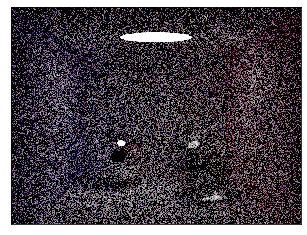

In [41]:
%matplotlib inline

import cv2
import PIL
from matplotlib import pyplot as plt
import numpy as np

img = cv2.imread('cpp-image.ppm')

plt.imshow(img)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

***
# Option 3:  Ambient occlusion


### What is ambient occlusion?
In computer graphics, **ambient occlusion** is a shading and rendering technique used to calculate how exposed each point in a scene is to ambient lighting. For example, the interior of a tube is typically more occluded (and hence darker) than the exposed outer surfaces, and the deeper you go inside the tube, the more occluded (and darker) the lighting becomes.


## Lesson 1:  Analysis of the Fujita ao-bench approach

In [42]:
%%writefile src/aobench.cpp

#include <stdio.h>
#include <stdlib.h>
#include <string.h>
#include <assert.h>
#include <math.h>

#define WIDTH        256
#define HEIGHT       256
#define NSUBSAMPLES  2
#define NAO_SAMPLES  8

typedef struct _vec
{
    double x;
    double y;
    double z;
} vec;


typedef struct _Isect
{
    double t;
    vec    p;
    vec    n;
    int    hit; 
} Isect;

typedef struct _Sphere
{
    vec    center;
    double radius;

} Sphere;

typedef struct _Plane
{
    vec    p;
    vec    n;

} Plane;

typedef struct _Ray
{
    vec    org;
    vec    dir;
} Ray;

Sphere spheres[3];
Plane  plane;

static double vdot(vec v0, vec v1)
{
    return v0.x * v1.x + v0.y * v1.y + v0.z * v1.z;
}

static void vcross(vec *c, vec v0, vec v1)
{
    
    c->x = v0.y * v1.z - v0.z * v1.y;
    c->y = v0.z * v1.x - v0.x * v1.z;
    c->z = v0.x * v1.y - v0.y * v1.x;
}

static void vnormalize(vec *c)
{
    double length = sqrt(vdot((*c), (*c)));

    if (fabs(length) > 1.0e-17) {
        c->x /= length;
        c->y /= length;
        c->z /= length;
    }
}

void
ray_sphere_intersect(Isect *isect, const Ray *ray, const Sphere *sphere)
{
    vec rs;

    rs.x = ray->org.x - sphere->center.x;
    rs.y = ray->org.y - sphere->center.y;
    rs.z = ray->org.z - sphere->center.z;

    double B = vdot(rs, ray->dir);
    double C = vdot(rs, rs) - sphere->radius * sphere->radius;
    double D = B * B - C;

    if (D > 0.0) {
        double t = -B - sqrt(D);
        
        if ((t > 0.0) && (t < isect->t)) {
            isect->t = t;
            isect->hit = 1;
            
            isect->p.x = ray->org.x + ray->dir.x * t;
            isect->p.y = ray->org.y + ray->dir.y * t;
            isect->p.z = ray->org.z + ray->dir.z * t;

            isect->n.x = isect->p.x - sphere->center.x;
            isect->n.y = isect->p.y - sphere->center.y;
            isect->n.z = isect->p.z - sphere->center.z;

            vnormalize(&(isect->n));
        }
    }
}

void
ray_plane_intersect(Isect *isect, const Ray *ray, const Plane *plane)
{
    double d = -vdot(plane->p, plane->n);
    double v = vdot(ray->dir, plane->n);

    if (fabs(v) < 1.0e-17) return;

    double t = -(vdot(ray->org, plane->n) + d) / v;

    if ((t > 0.0) && (t < isect->t)) {
        isect->t = t;
        isect->hit = 1;
        
        isect->p.x = ray->org.x + ray->dir.x * t;
        isect->p.y = ray->org.y + ray->dir.y * t;
        isect->p.z = ray->org.z + ray->dir.z * t;

        isect->n = plane->n;
    }
}

void
orthoBasis(vec *basis, vec n)
{
    basis[2] = n;
    basis[1].x = 0.0; basis[1].y = 0.0; basis[1].z = 0.0;

    if ((n.x < 0.6) && (n.x > -0.6)) {
        basis[1].x = 1.0;
    } else if ((n.y < 0.6) && (n.y > -0.6)) {
        basis[1].y = 1.0;
    } else if ((n.z < 0.6) && (n.z > -0.6)) {
        basis[1].z = 1.0;
    } else {
        basis[1].x = 1.0;
    }

    vcross(&basis[0], basis[1], basis[2]);
    vnormalize(&basis[0]);

    vcross(&basis[1], basis[2], basis[0]);
    vnormalize(&basis[1]);
}


void ambient_occlusion(vec *col, const Isect *isect)
{
    int    i, j;
    int    ntheta = NAO_SAMPLES;
    int    nphi   = NAO_SAMPLES;
    double eps = 0.0001;

    vec p;

    p.x = isect->p.x + eps * isect->n.x;
    p.y = isect->p.y + eps * isect->n.y;
    p.z = isect->p.z + eps * isect->n.z;

    vec basis[3];
    orthoBasis(basis, isect->n);

    double occlusion = 0.0;

    for (j = 0; j < ntheta; j++) {
        for (i = 0; i < nphi; i++) {
            double theta = sqrt(drand48());
            double phi   = 2.0 * M_PI * drand48();

            double x = cos(phi) * theta;
            double y = sin(phi) * theta;
            double z = sqrt(1.0 - theta * theta);

            // local -> global
            double rx = x * basis[0].x + y * basis[1].x + z * basis[2].x;
            double ry = x * basis[0].y + y * basis[1].y + z * basis[2].y;
            double rz = x * basis[0].z + y * basis[1].z + z * basis[2].z;

            Ray ray;

            ray.org = p;
            ray.dir.x = rx;
            ray.dir.y = ry;
            ray.dir.z = rz;

            Isect occIsect;
            occIsect.t   = 1.0e+17;
            occIsect.hit = 0;

            ray_sphere_intersect(&occIsect, &ray, &spheres[0]); 
            ray_sphere_intersect(&occIsect, &ray, &spheres[1]); 
            ray_sphere_intersect(&occIsect, &ray, &spheres[2]); 
            ray_plane_intersect (&occIsect, &ray, &plane); 

            if (occIsect.hit) occlusion += 1.0;
            
        }
    }

    occlusion = (ntheta * nphi - occlusion) / (double)(ntheta * nphi);

    col->x = occlusion;
    col->y = occlusion;
    col->z = occlusion;
}

unsigned char
clamp(double f)
{
  int i = (int)(f * 255.5);

  if (i < 0) i = 0;
  if (i > 255) i = 255;

  return (unsigned char)i;
}


void
render(unsigned char *img, int w, int h, int nsubsamples)
{
    int x, y;
    int u, v;

    double *fimg = (double *)malloc(sizeof(double) * w * h * 3);
    memset((void *)fimg, 0, sizeof(double) * w * h * 3);

    for (y = 0; y < h; y++) {
        for (x = 0; x < w; x++) {
            
            for (v = 0; v < nsubsamples; v++) {
                for (u = 0; u < nsubsamples; u++) {
                    double px = (x + (u / (double)nsubsamples) - (w / 2.0)) / (w / 2.0);
                    double py = -(y + (v / (double)nsubsamples) - (h / 2.0)) / (h / 2.0);

                    Ray ray;

                    ray.org.x = 0.0;
                    ray.org.y = 0.0;
                    ray.org.z = 0.0;

                    ray.dir.x = px;
                    ray.dir.y = py;
                    ray.dir.z = -1.0;
                    vnormalize(&(ray.dir));

                    Isect isect;
                    isect.t   = 1.0e+17;
                    isect.hit = 0;

                    ray_sphere_intersect(&isect, &ray, &spheres[0]);
                    ray_sphere_intersect(&isect, &ray, &spheres[1]);
                    ray_sphere_intersect(&isect, &ray, &spheres[2]);
                    ray_plane_intersect (&isect, &ray, &plane);

                    if (isect.hit) {
                        vec col;
                        ambient_occlusion(&col, &isect);

                        fimg[3 * (y * w + x) + 0] += col.x;
                        fimg[3 * (y * w + x) + 1] += col.y;
                        fimg[3 * (y * w + x) + 2] += col.z;
                    }

                }
            }

            fimg[3 * (y * w + x) + 0] /= (double)(nsubsamples * nsubsamples);
            fimg[3 * (y * w + x) + 1] /= (double)(nsubsamples * nsubsamples);
            fimg[3 * (y * w + x) + 2] /= (double)(nsubsamples * nsubsamples);
        
            img[3 * (y * w + x) + 0] = clamp(fimg[3 *(y * w + x) + 0]);
            img[3 * (y * w + x) + 1] = clamp(fimg[3 *(y * w + x) + 1]);
            img[3 * (y * w + x) + 2] = clamp(fimg[3 *(y * w + x) + 2]);
        }
    }

}

void
init_scene()
{
    spheres[0].center.x = -2.0;
    spheres[0].center.y =  0.0;
    spheres[0].center.z = -3.5;
    spheres[0].radius = 0.5;
    
    spheres[1].center.x = -0.5;
    spheres[1].center.y =  0.0;
    spheres[1].center.z = -3.0;
    spheres[1].radius = 0.5;
    
    spheres[2].center.x =  1.0;
    spheres[2].center.y =  0.0;
    spheres[2].center.z = -2.2;
    spheres[2].radius = 0.5;

    plane.p.x = 0.0;
    plane.p.y = -0.5;
    plane.p.z = 0.0;

    plane.n.x = 0.0;
    plane.n.y = 1.0;
    plane.n.z = 0.0;

}

void
saveppm(const char *fname, int w, int h, unsigned char *img)
{
    FILE *fp;

    fp = fopen(fname, "wb");
    assert(fp);

    fprintf(fp, "P6\n");
    fprintf(fp, "%d %d\n", w, h);
    fprintf(fp, "255\n");
    fwrite(img, w * h * 3, 1, fp);
    fclose(fp);
}

int
main(int argc, char **argv)
{
    unsigned char *img = (unsigned char *)malloc(WIDTH * HEIGHT * 3);

    init_scene();

    render(img, WIDTH, HEIGHT, NSUBSAMPLES);

    saveppm("ao.ppm", WIDTH, HEIGHT, img); 

    return 0;
}

Overwriting src/aobench.cpp


In [43]:
! dpcpp src/aobench.cpp -o aobench -O3 -std=c++11

In [44]:
%%time

! ./aobench

CPU times: user 21.4 ms, sys: 8.6 ms, total: 30 ms
Wall time: 884 ms


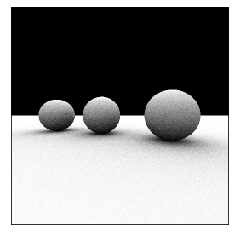

In [45]:
%matplotlib inline

import cv2
import PIL
from matplotlib import pyplot as plt
import numpy as np

img = cv2.imread('ao.ppm')

plt.imshow(img)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

***
# Summary/Conclusion

***
# References
* **Physically Based Rendering: From Theory to Implementation, Third Edition**; Matt Pharr, Wenzel Jakob, and Greg Humphreys.  http://pbrt.org
* **The Graphics Codex; Morgan McGuire; 2018**.  http://graphicscodex.com
* **AOBench: ambient occlusion benchmark; Syoyo Fujita**.  https://github.com/syoyo/aobench
* **Understandable RayTracing in 256 lines of bare C++; Dmitry V. Sokolov**. https://github.com/ssloy/tinyraytracer/wiki/Part-1:-understandable-raytracing
* **smallpt: Global Illumination in 99 lines of C++; Kevin Beason**. https://www.kevinbeason.com/smallpt/
* **Electronic Arts Standard Template Library**; https://github.com/electronicarts/EASTL
* **linalg.h - v2.0 - Single-header public domain linear algebra library**; Sterling G. Orsten. http://github.com/sgorsten/linalg/
* **Intel(r) OSPRay:  The Open, Scalable, and Portable Ray Tracing Engine**; https://www.ospray.org/
* **Intel(r) Embree:  High Performance Ray Tracing Kernels**; https://www.embree.org/
* **stb single-file public domain libraries for C/C++**; https://github.com/nothings/stb